### **CC57 - MACHINE LEARNING - APRENDIZAJE SEMI-SUPERVISADO CON CLUSTERING**

Se trabajara con un conjunto de datos de imagenes de prendas de vestir llamado **fashion_mnist** cargado desde **tensorflow.keras.datasets** compuesto por 70,000 imagenes etiquetadas.

In [2]:
#Inicializacion de librerias
from tensorflow.keras.datasets.fashion_mnist import load_data
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import numpy as np

In [3]:
#Carga de datos de entrenamiento y prueba
(x_train, y_train), (x_test, y_test) = load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

4422102/4422102 [==============================] - 0s 0us/step


In [4]:
#Asignacion de etiquetas de las prendas en una lista
labels = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot',
]

<ipython-input-5-67a91955a446>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(5, 10, i + 1)


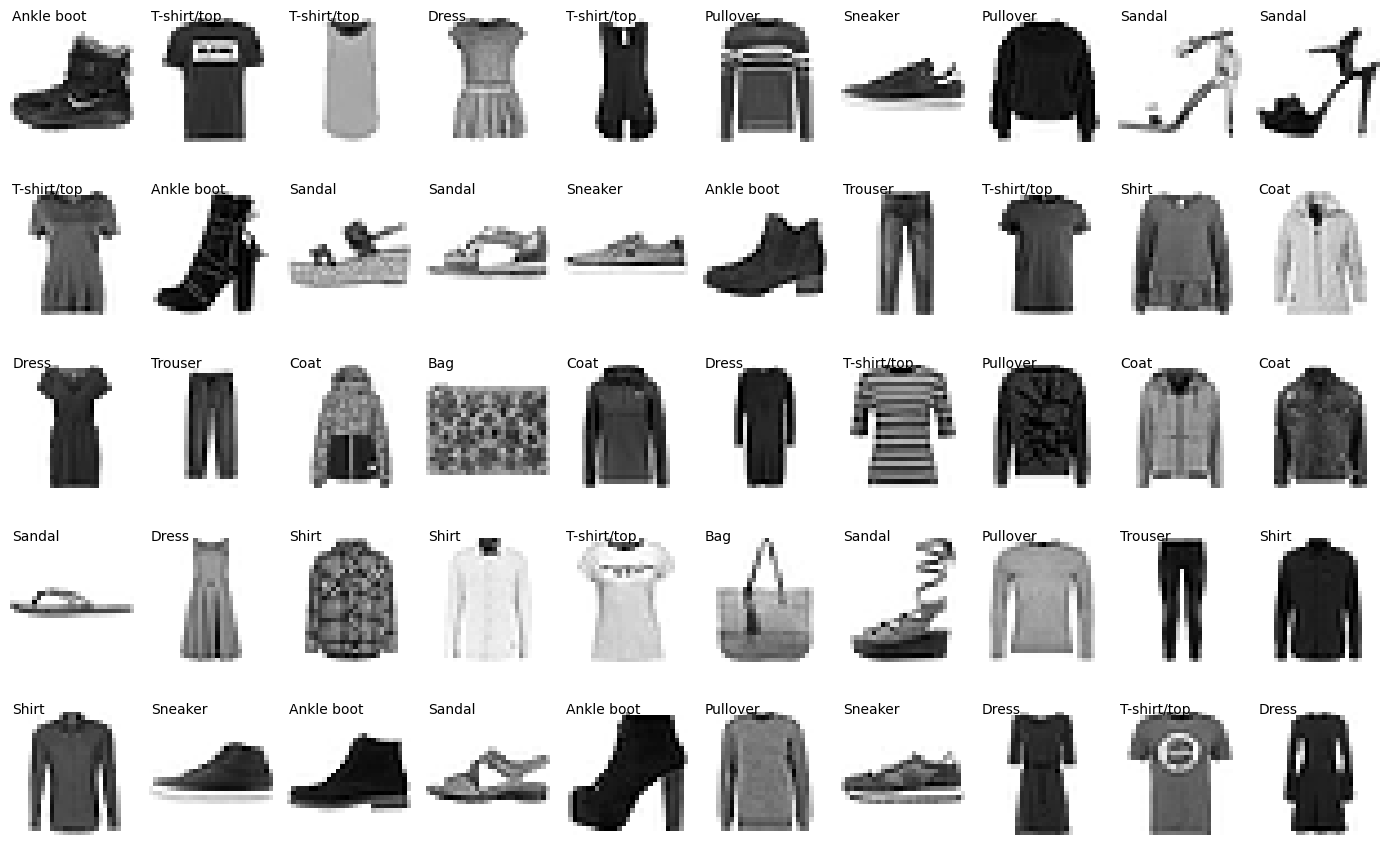

In [5]:
#Visualizacion de las 50 primeras prendas en escala de grises
plt.subplots(figsize=(14, 9))
for i in range(50):
    ax = plt.subplot(5, 10, i + 1)
    ax.imshow(x_train[i], cmap='gray_r')
    ax.axis('off')
    ax.text(0, 0, labels[y_train[i]])

plt.tight_layout()
plt.show()

In [6]:
#Dividimos el conjunto de datos en conjunto de entrenamiento (60000) y prueba (10000)
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(60000, 784) (60000,)
(10000, 784) (10000,)


In [18]:
#Creamos un clasificador de regresion logistica y lo entrenamos solamente con hasta 2000 imagenes (no con las 60000)
m = 2000

#Para un max_iter=5000 se recomienda escalar los datos de entrenamiento
lr = LogisticRegression(multi_class='ovr', solver='lbfgs', max_iter=8000, random_state=42)
lr.fit(x_train[:m], y_train[:m])

LogisticRegression(max_iter=8000, multi_class='ovr', random_state=42)

In [19]:
#Evaluamos el la precision del clasificador de regresion logistica
lr.score(x_test, y_test)

0.7628

In [20]:
#Ahora creamos y entrenamos un clasificador kmeans, tambien con 2000 imagenes
#Se crean 100 clusters y se obtienen las imagenes mas representativos del conjunto de entranamiento
k = 100
kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
X_digits_dist = kmeans.fit_transform(x_train[:m])
#np.argmin: Devuelve los índices de los valores mínimos a lo largo de un eje
# (los que estan mas cerca al centroide)
representative_digit_idx = np.argmin(X_digits_dist, axis=0)
X_representative_digits = x_train[representative_digit_idx]

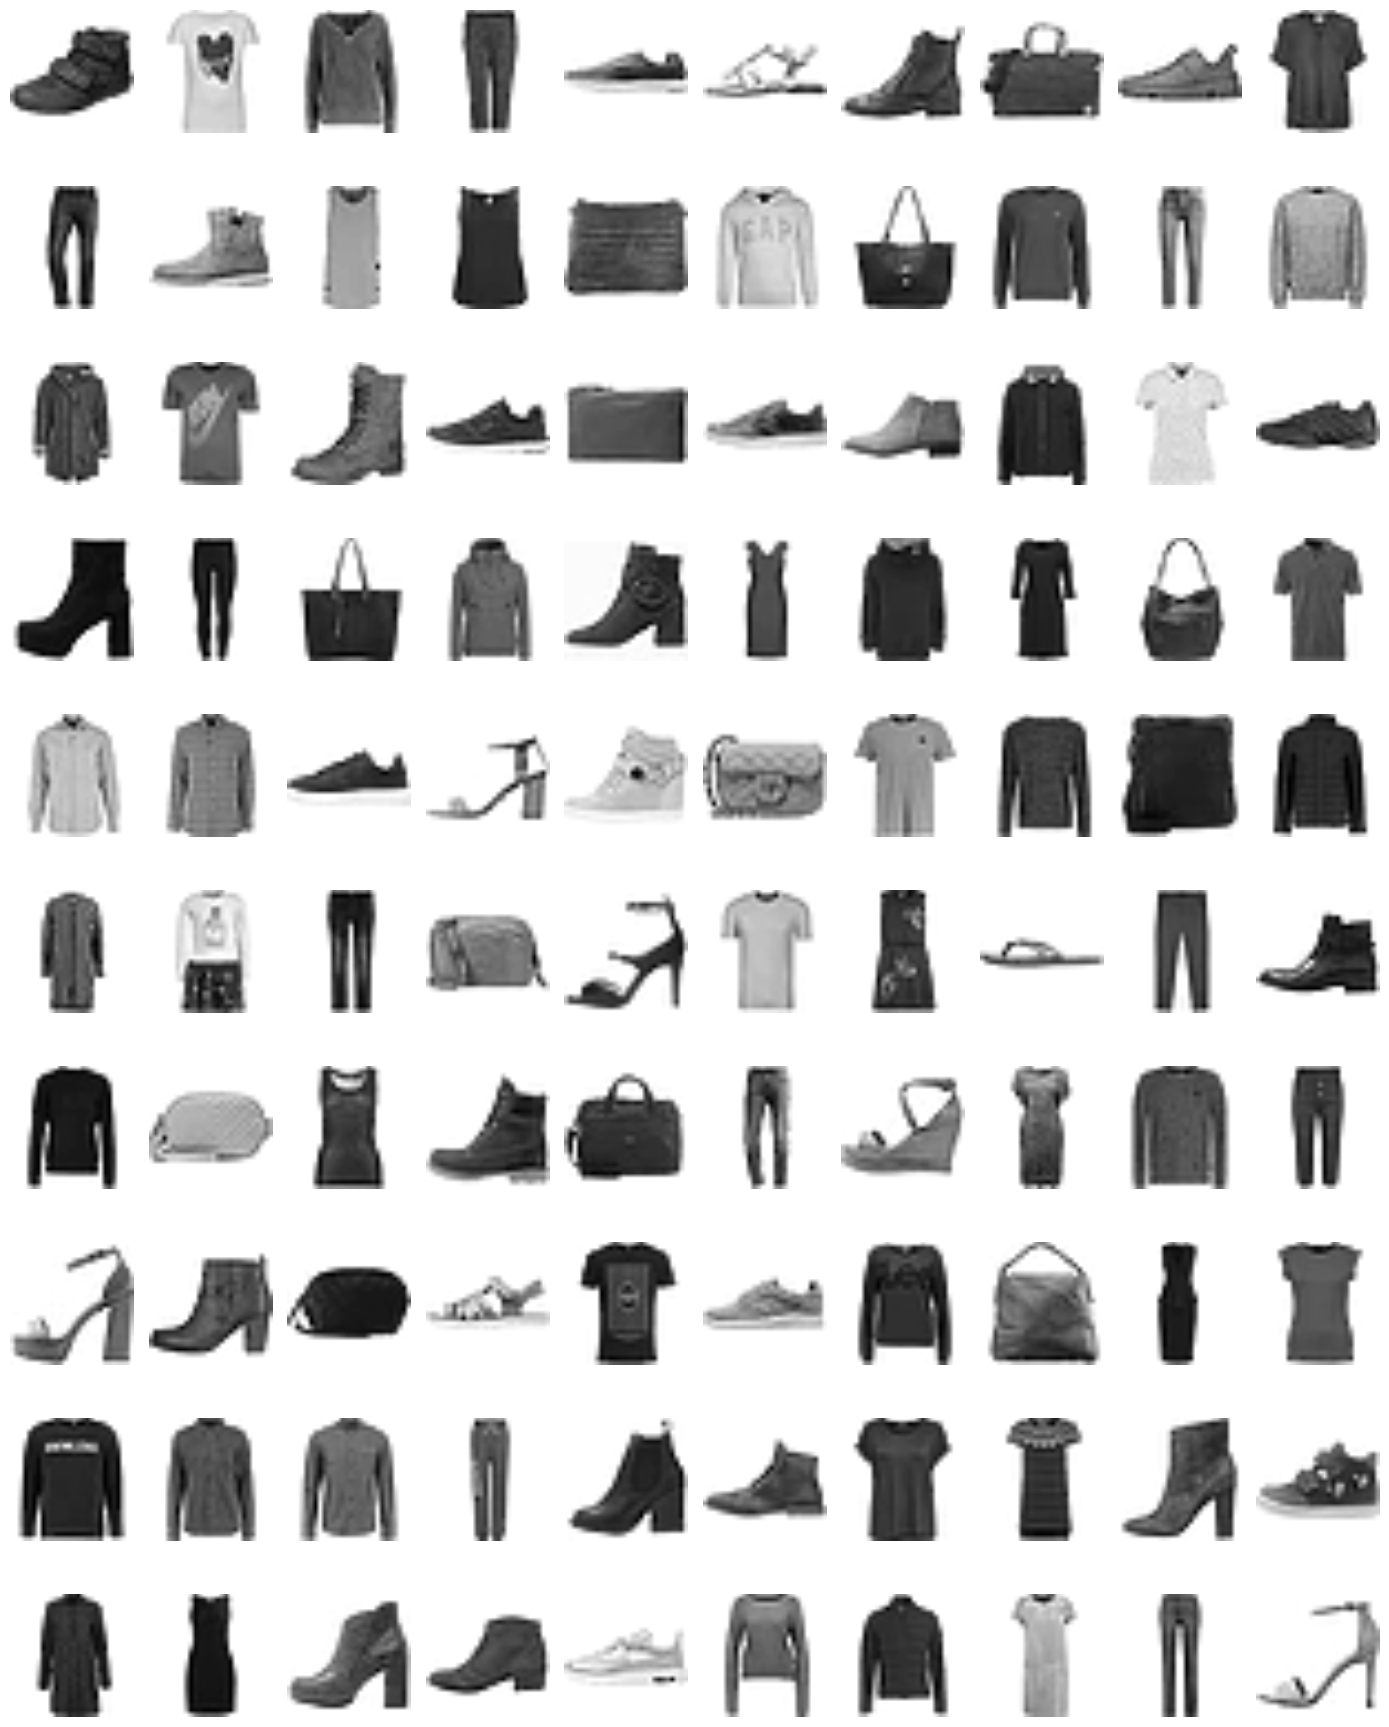

In [21]:
#Visualizamos los images mas representativas del conjunto de datos den entrenamiento
plt.figure(figsize=(14, 18))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(28, 28), cmap='binary', interpolation='bilinear')
    #plt.title(f"{labels[y_train[representative_digit_idx[index]]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

Hemos creado 100 grupos con la esperanza de que cada uno de las 10 prendas de vestir del 0 al 9 en la **lista labels** sea el más común en al menos 1 de los 100. Como podemos ver en la imagen anterior, cada prenda es la más representativa más de una vez.  Probar con un k = 50.

A partir de los dígitos representativos, creamos manualmente una matriz de etiquetas para entrenar un clasificador.

In [22]:
y_byhand = np.array(
    [7, 0, 2, 1, 7, 5, 9, 8, 7, 6, 1, 9, 0, 6, 8, 2, 8, 2, 1, 2, 4, 0,
     9, 7, 8, 7, 9, 4, 0, 7, 9, 1, 8, 4, 9, 3, 2, 3, 8, 0, 6, 6, 7, 5,
     7, 8, 0, 2, 8, 4, 3, 3, 1, 8, 5, 0, 3, 5, 1, 9, 2, 8, 0, 9, 8, 1,
     5, 3, 2, 1, 5, 9, 8, 5, 0, 7, 2, 8, 3, 0, 2, 6, 6, 1, 9, 9, 0, 3,
     9, 7, 6, 3, 9, 9, 7, 2, 4, 3, 1, 5])

In [23]:
#Ahora, entrenamos el clasificador de regresion logistica con los digitos representativos obtenidos de la segmentacion anterior
lr = LogisticRegression(multi_class='ovr', solver='lbfgs', max_iter=8000, random_state=42)
lr.fit(X_representative_digits, y_byhand)
lr.score(x_test, y_test)

0.7049

Propagar la imagen identificada a todas las demás instancias de cada grupo correspondiente.

In [14]:
y_train_propagated = np.empty(m, dtype=int)
for i in range(k):
    y_train_propagated[kmeans.labels_ == i] = y_byhand[i]

In [24]:
#Entrenamos nuevamente el clasificador de regresion logistica pero con la variable objetiva propagada y_train_propagated
lr = LogisticRegression(multi_class='ovr', solver='lbfgs', max_iter=8000, random_state=42)
lr.fit(x_train[:m], y_train_propagated)
lr.score(x_test, y_test)

0.6545

In [25]:
#La media obtenida entre la variable objetivo propagada y la real
np.mean(y_train_propagated == y_train[:m])

0.6955

**Tarea:**

Al igual que en el notebook **17_02_aprendizaje_semisupervisado.ipynb**:

- Propagar solo al percentil 75 de las instancias más cercanas al centroide de cada grupo.

- Entrenar nuevamente el clasificador de regresion logistica pero con la variable objetiva parcialmente propagada cercana al percentil 75 partially_propagated.

- Obtener la media entre la variable objetivo propagada y la real.
- Obtener la media obtenida la variable objetivo parcialmente propagada y la real parcialmente propagada